In [1]:
%pylab inline
%load_ext nb_black
import numpy as np
import requests, gzip, os, hashlib, numpy
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange
from torchvision import datasets
from torchvision.transforms import ToTensor

Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>

In [2]:
def fetch(url):

    fp = os.path.join("/home/wan268/tmp/", hashlib.md5(url.encode("utf-8")).hexdigest())
    if os.path.isfile(fp):
        with open(fp, "rb") as f:
            dat = f.read()
    else:
        with open(fp, "wb") as f:
            dat = requests.get(url).content
            f.write(dat)
    return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()


X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[
    0x10:
].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[
    0x10:
].reshape((-1, 28 * 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

<IPython.core.display.Javascript object>

In [3]:
class MnistNet(nn.Module):
    def __init__(self):
        super(MnistNet, self).__init__()
        self.l1 = nn.Linear(784, 128)
        self.act = nn.ReLU()
        self.l2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.l1(x)
        x = self.act(x)
        x = self.l2(x)
        return x

<IPython.core.display.Javascript object>

In [4]:
# CPU
model = MnistNet()
BS = 32
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
losses, accuracies = [], []
for i in (t := trange(2000)) :
    samp = np.random.randint(0, X_train.shape[0], size=BS)
    X = torch.tensor(X_train[samp].reshape((-1, 28 * 28))).float()
    Y = torch.tensor(Y_train[samp]).long()
    optimizer.zero_grad()
    out = model(X)
    cat = torch.argmax(out, dim=1)
    accuracy = (cat == Y).float().mean()
    loss = loss_function(out, Y)
    loss.backward()
    optimizer.step()
    loss, accuracy = (loss.item(), accuracy.item())
    losses.append(loss)
    accuracies.append(accuracy)
    t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))

loss 0.07 accuracy 1.00: 100%|██████████| 2000/2000 [00:07<00:00, 270.79it/s]


<IPython.core.display.Javascript object>

0.9249

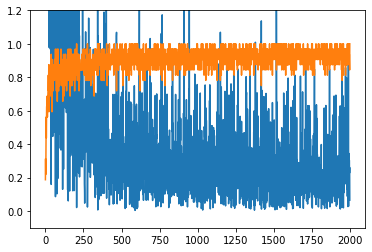

<IPython.core.display.Javascript object>

In [5]:
plt.ylim(-0.1, 1.2)
plot(losses)
plot(accuracies)

Y_test_preds = torch.argmax(
    model(torch.tensor(X_test.reshape((-1, 28 * 28))).float()), dim=1
).numpy()
(Y_test == Y_test_preds).mean()

In [16]:
# GPU
device = torch.device("cuda:0")
model = MnistNet().to(device)
BS = 32
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
losses, accuracies = [], []
X_train_cuda = torch.tensor(X_train.reshape((-1, 28 * 28))).float().to(device)
Y_train_cuda = torch.tensor(Y_train).long().to(device)

for i in (t := trange(2000)) :
    samp = np.random.randint(0, X_train.shape[0], size=BS)
    X = X_train_cuda[samp]
    Y = Y_train_cuda[samp]

    out = model(X).to(device)
    cat = torch.argmax(out, dim=1)
    accuracy = (cat == Y).float().mean()
    loss = loss_function(out, Y)
    optimizer.zero_grad()
    loss.backward()

    optimizer.step()
    loss, accuracy = (loss.item(), accuracy.item())
    losses.append(loss)
    accuracies.append(accuracy)
    t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))

loss 0.15 accuracy 0.94: 100%|██████████| 2000/2000 [00:02<00:00, 768.67it/s]


<IPython.core.display.Javascript object>

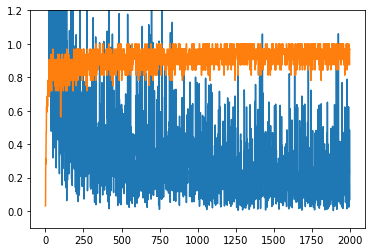

<IPython.core.display.Javascript object>

In [12]:
plt.ylim(-0.1, 1.2)
plot(losses)
plot(accuracies)


In [13]:
Y_test_preds = (
    torch.argmax(
        model(torch.tensor(X_test.reshape((-1, 28 * 28))).float().to(device)), dim=1,
    )
    .cpu()
    .numpy()
)
(Y_test == Y_test_preds).mean()

0.9421

<IPython.core.display.Javascript object>